In [133]:
import os
import sys
import shutil
import time
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from cifar10_data import CIFAR10RandomLabels
from torch.autograd import Variable
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import math
import copy
import torch.nn.functional as F

In [134]:
class MLP(nn.Module):
  def __init__(self, n_units, init_scale=1.0):
    super(MLP, self).__init__()

    self._n_units = copy.copy(n_units)
    self._layers = []
    for i in range(1, len(n_units)):
      layer = nn.Linear(n_units[i-1], n_units[i], bias=False)
      self._layers.append(layer)

      name = 'fc%d' % i
      if i == len(n_units) - 1:
        name = 'fc'  # the prediction layer is just called fc
      self.add_module(name, layer)


  def forward(self, x):
    x = x.view(-1, self._n_units[0])
    out = self._layers[0](x)
    for layer in self._layers[1:]:
      out = F.relu(out)
      out = layer(out)
    return out


In [135]:
n_units = [512]
n_units.append(10)
n_units.insert(0, 32*32*3) 


In [136]:
model = MLP(n_units)
model_state = torch.load('model_nocorrupt', map_location=lambda storage, loc: storage)
model.load_state_dict(model_state)
model.eval()

model_random =MLP(n_units)
model_random_state = torch.load('model_corrupt', map_location=lambda storage, loc: storage)
model_random.load_state_dict(model_random_state)
model_random.eval()


MLP(
  (fc1): Linear(in_features=3072, out_features=512)
  (fc): Linear(in_features=512, out_features=10)
)

In [137]:
def cal_margin(trainloader, model):
#     model = AlexNet(num_classes)
#     model_state = torch.load('model_'+str(iterations[i]), map_location=lambda storage, loc: storage)
#     model.load_state_dict(model_state)
    margin = []
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inp = inputs
        tar = targets
        b = model(Variable(inputs))
        c = b.topk(2)[0][:,1].data.numpy()
        bnp = b.data.numpy()
        for j in range(b.shape[0]):
            margin.append(bnp[j,tar[j]]-c[j])
    margin = np.array(margin)
    return margin

In [13]:
normalize = transforms.Normalize(mean=[x/255.0 for x in [125.3, 123.0, 113.9]],
                                 std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
transform_train = transforms.Compose([
transforms.ToTensor(),
normalize
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize
    ])
dataloader = datasets.CIFAR10
num_classes = 10
train_batch = 128
test_batch = 100
workers = 4
trainloader = data.DataLoader(
    CIFAR10RandomLabels(root='/Users/hanxintian/Downloads/1005project/inference_project/cifar10Alexnet/data', train=True, download=True,
                    num_classes=num_classes, transform = transform_train,
                        corrupt_prob=0.0),
    batch_size=train_batch, shuffle=True, num_workers=workers)

Files already downloaded and verified


In [14]:
normalize = transforms.Normalize(mean=[x/255.0 for x in [125.3, 123.0, 113.9]],
                                 std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
transform_train = transforms.Compose([
transforms.ToTensor(),
normalize
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize
    ])
dataloader = datasets.CIFAR10
num_classes = 10
train_batch = 128
test_batch = 100
workers = 4
trainloader_random = data.DataLoader(
    CIFAR10RandomLabels(root='/Users/hanxintian/Downloads/1005project/inference_project/cifar10Alexnet/data', train=True, download=True,
                    num_classes=num_classes, transform = transform_train,
                        corrupt_prob=1.0),
    batch_size=train_batch, shuffle=True, num_workers=workers)

Files already downloaded and verified


In [138]:
margin = cal_margin( trainloader, model)

In [139]:
margin_random = cal_margin( trainloader_random, model_random)

In [116]:
testloader = data.DataLoader(
    CIFAR10RandomLabels(root='/Users/hanxintian/Downloads/1005project/inference_project/cifar10Alexnet/data', train=False, download=True,
                    num_classes=num_classes, transform = transform_train,
                        corrupt_prob=0.0),
    batch_size=train_batch, shuffle=True, num_workers=workers)
testloader_random = data.DataLoader(
    CIFAR10RandomLabels(root='/Users/hanxintian/Downloads/1005project/inference_project/cifar10Alexnet/data', train=False, download=True,
                    num_classes=num_classes, transform = transform_train,
                        corrupt_prob=1.0),
    batch_size=train_batch, shuffle=True, num_workers=workers)

Files already downloaded and verified
Files already downloaded and verified


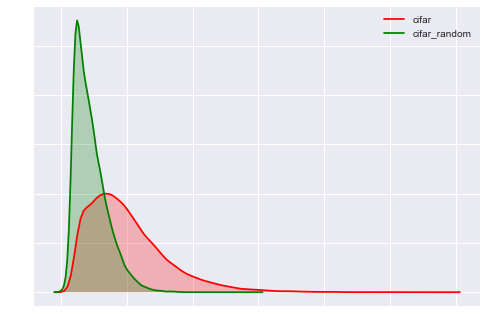

In [140]:
sns.set_style({'ytick.color': 'w'})
sns.set_style({'xtick.color': 'w'})
sns.distplot(margin, hist=False, color='r', kde_kws={"shade": True}, label = 'cifar')
sns.distplot(margin_random, hist=False, color='g', kde_kws={"shade": True}, label = 'cifar_random')
plt.savefig('margin_MLP', bbox_inches='tight')
plt.show()

In [40]:
def cal_complexity(model):
    comp = 1.0
    plu = 0.0
    A1_spec = np.linalg.norm(model._layers[0].weight.data.numpy(), ord = 2)
    A1_lin1 = torch.norm(model._layers[0].weight.view(-1).data, p = 1)
    A2_spec = np.linalg.norm(model._layers[1].weight.data.numpy(), ord = 2)
    A2_lin1 = torch.norm(model._layers[1].weight.view(-1).data, p = 1)
    plu+= (A1_lin1/A1_spec)**(2.0/3)
    plu+= (A2_lin1/A2_spec)**(2.0/3)
    comp = comp*A1_spec*A2_spec*(plu**(3.0/2))
    return comp

In [51]:
def cal_m_complexity(model):
    comp = 1.0
    plu = 0.0
    A1_spec = np.linalg.norm(model._layers[0].weight.data.numpy(), ord = 2)
    A1_lin2 = torch.norm(model._layers[0].weight.view(-1).data, p = 2)
    A2_spec = np.linalg.norm(model._layers[1].weight.data.numpy(), ord = 2)
    A2_lin2 = torch.norm(model._layers[1].weight.view(-1).data, p = 2)
    plu+= (A1_lin2/A1_spec)**(2.0/3)
    plu+= (A2_lin2/A2_spec)**(2.0/3)
    comp = comp*A1_spec*A2_spec*(plu**(3.0/2))
    return comp

In [141]:
comp = cal_complexity(model)
comp_random = cal_complexity(model_random)

In [142]:
comp

720749.9786563305

In [143]:
comp_random

484683.39910763444

In [42]:
ratio = comp_random/comp

In [144]:
comp_m = cal_m_complexity(model)
comp_m_random = cal_m_complexity(model_random)

In [145]:
comp_m_random/comp_m

0.6840388521358538

In [132]:
np.linalg.norm(model_random._layers[0].weight.data.numpy(), ord = 1)

35.7099

In [131]:
np.linalg.norm(model._layers[0].weight.data.numpy(), ord = 1)

27.680691

In [130]:
np.linalg.norm(model._layers[1].weight.data.numpy(), ord = 1)

2.6315098

In [129]:
np.linalg.norm(model_random._layers[1].weight.data.numpy(), ord = 1)

1.9903992

In [48]:
model.named_parameters

<bound method Module.named_parameters of MLP(
  (fc1): Linear(in_features=3072, out_features=512)
  (fc): Linear(in_features=512, out_features=10)
)>

In [117]:
def softmax(x):
    xmax = np.max(x)
    return(np.exp(x)/sum(np.exp(x)))
def cal_fr(testloader, model):
#     model = AlexNet(num_classes)
#     model_state = torch.load('model_'+str(iterations[i]), map_location=lambda storage, loc: storage)
#     model.load_state_dict(model_state)
    fr = []
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inp = inputs
        tar = targets
        b = model(Variable(inputs))
        bsm = F.softmax(b, dim = 1)
        bsm = bsm.data.numpy()
        bnp = b.data.numpy()
        for j in range(b.shape[0]):
            fr0 = (np.dot(bsm[j],bnp[j])-bnp[j,tar[j]])**2
            fr.append(fr0)
    fr = np.array(fr)
    fr = sum(fr)
    return fr

In [118]:
fr = cal_fr(testloader, model)
fr_random = cal_fr(testloader_random, model_random)

0.58021586900915412

In [120]:
fr_random

1474614.2491689611

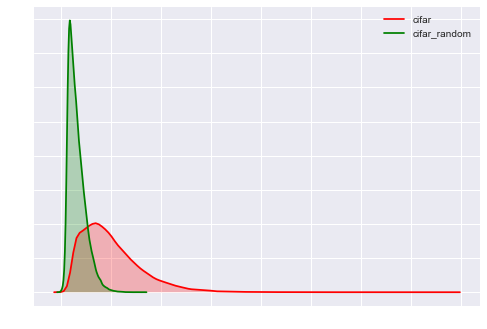

In [94]:
sns.set_style({'ytick.color': 'w'})
sns.set_style({'xtick.color': 'w'})
sns.distplot(margin, hist=False, color='r', kde_kws={"shade": True}, label = 'cifar')
sns.distplot(margin_random*0.68, hist=False, color='g', kde_kws={"shade": True}, label = 'cifar_random')
plt.savefig('s_margin_MLP', bbox_inches='tight')
plt.show()

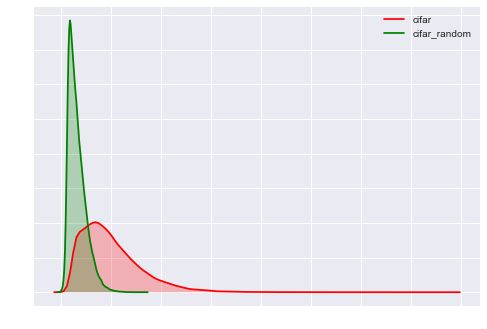

In [95]:
sns.set_style({'ytick.color': 'w'})
sns.set_style({'xtick.color': 'w'})
sns.distplot(margin, hist=False, color='r', kde_kws={"shade": True}, label = 'cifar')
sns.distplot(margin_random*0.69, hist=False, color='g', kde_kws={"shade": True}, label = 'cifar_random')
plt.savefig('m_margin_MLP', bbox_inches='tight')
plt.show()

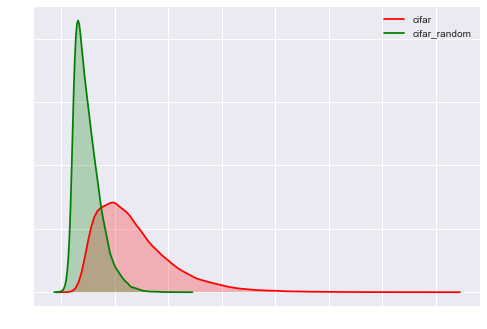

In [122]:
sns.set_style({'ytick.color': 'w'})
sns.set_style({'xtick.color': 'w'})
sns.distplot(margin, hist=False, color='r', kde_kws={"shade": True}, label = 'cifar')
sns.distplot(margin_random*0.58, hist=False, color='g', kde_kws={"shade": True}, label = 'cifar_random')
plt.savefig('f_margin_MLP', bbox_inches='tight')
plt.show()